<a href="https://colab.research.google.com/github/garridoeduardo1000-afk/Simulacion-2-Eduardo-Gonzalez-/blob/main/Copia_de_Modelodevolatilidadestocastica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

rng = np.random.RandomState(1234)
az.style.use("arviz-darkgrid")

INTRODUCCION

si observamos  el precio de una acción en la bolsa. Algunos días el precio sube o baja mucho (es muy volátil) y otros días casi no se mueve (es muy estable). Este cuaderno  describe un modelo matemático que intenta capturar ese comportamiento, mas especificamente un modelo de volatilidad estocastica, modelado como un proceso estocastico de la siguiente forma:

σ ~ Exponential(50)

ν ~ Exponential(0.1)

sᵢ ~ Normal(sᵢ₋₁, σ⁻²)

log(rᵢ) ~ t(ν, 0, exp(-2sᵢ))

CREACION DEL MODELO

Primero, cargamos los rendimientos diarios del S&P 500 y calculamos su logaritmo. Estos datos corresponden al período comprendido entre mayo de 2008 y noviembre de 2019.

In [ ]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()

,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


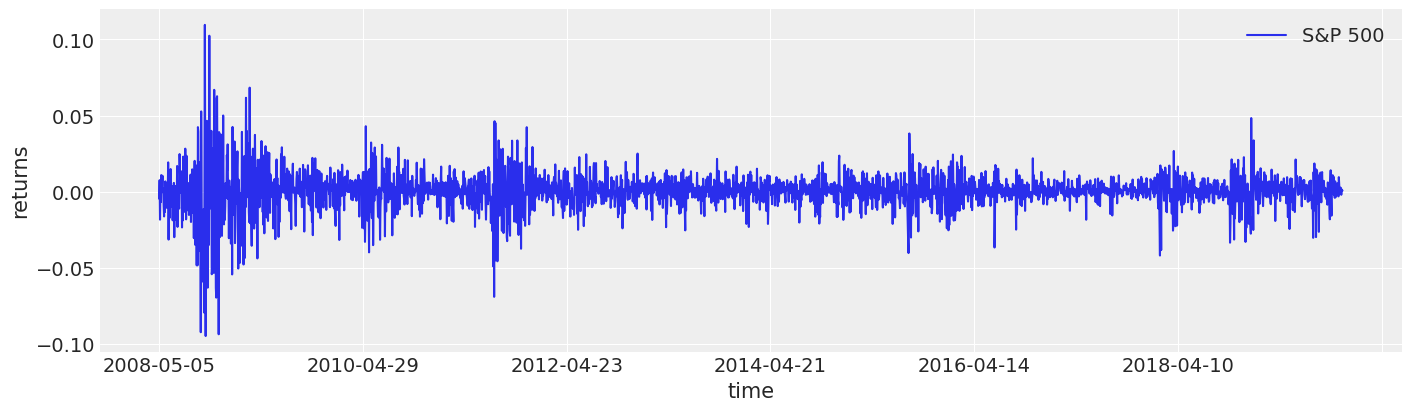

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

Pasando a la creacion del modelo:

In [ ]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk(
            "volatility", sigma=step_size, dims="time", init_dist=pm.Normal.dist(0, 100)
        )
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

Comprobar nuestro modelo

Dos buenas cosas que podemos hacer para asegurarnos de que nuestro modelo sea el que esperamos es:

Observe la estructura del modelo. Esto nos permite saber que especificamos las probabilidades previas y las conexiones deseadas. También es útil recordar el tamaño de las variables aleatorias.

Analice las muestras predictivas previas. Esto nos ayuda a interpretar lo que nuestras predicciones previas implican sobre los datos.

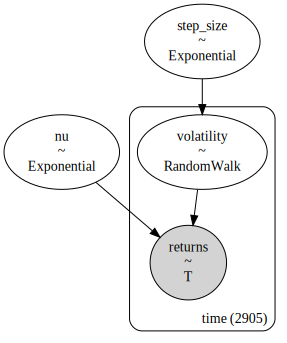

In [ ]:
pm.model_to_graphviz(stochastic_vol_model)

In [ ]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = az.extract(idata, group="prior_predictive")

Graficamos e inspeccionamos la predicción a priori.

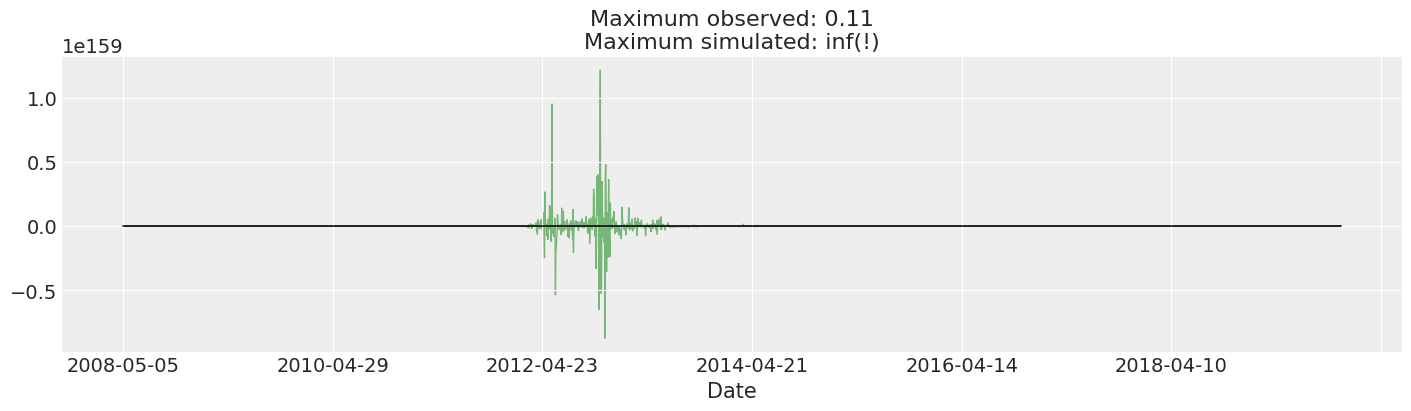

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"][:, 0::10],
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

In [ ]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

rng = np.random.default_rng(1234)
az.style.use("arviz-darkgrid")

In [ ]:
try:
    returns = pd.read_csv(os.path.join("..", "data", "SP500.csv"), index_col="Date")
except FileNotFoundError:
    returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")

returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()

returns.head()

,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


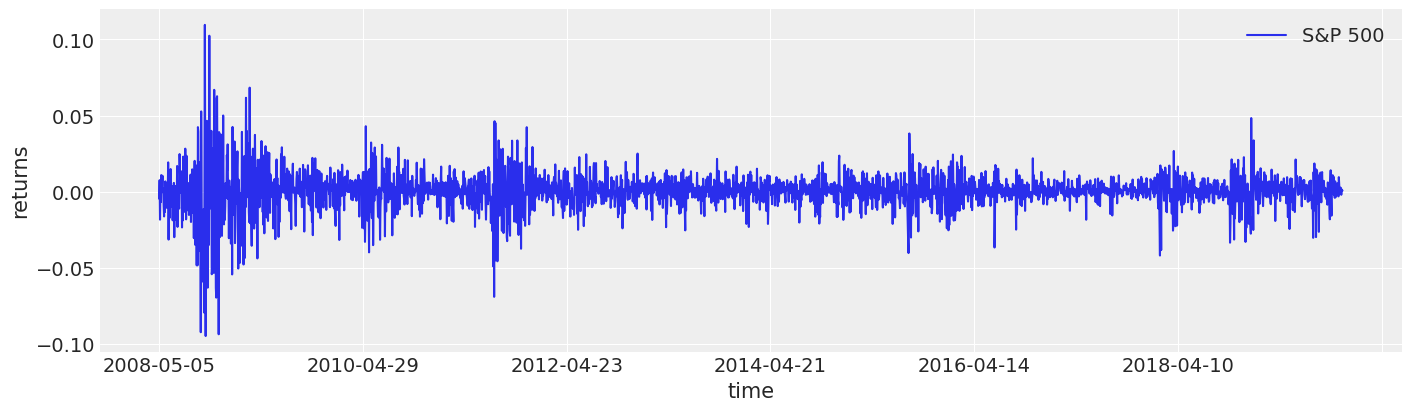

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

In [ ]:
def make_stochastic_volatility_model(data):
    with pm.Model(coords={"time": data.index.values}) as model:
        step_size = pm.Exponential("step_size", 10)
        volatility = pm.GaussianRandomWalk(
            "volatility", sigma=step_size, dims="time", init_dist=pm.Normal.dist(0, 100)
        )
        nu = pm.Exponential("nu", 0.1)
        returns = pm.StudentT(
            "returns", nu=nu, lam=np.exp(-2 * volatility), observed=data["change"], dims="time"
        )
    return model


stochastic_vol_model = make_stochastic_volatility_model(returns)

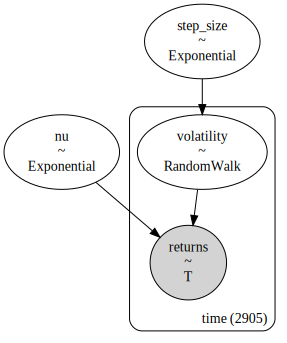

In [ ]:
pm.model_to_graphviz(stochastic_vol_model)

In [ ]:
with stochastic_vol_model:
    idata = pm.sample_prior_predictive(500, random_seed=rng)

prior_predictive = az.extract(idata, group="prior_predictive")

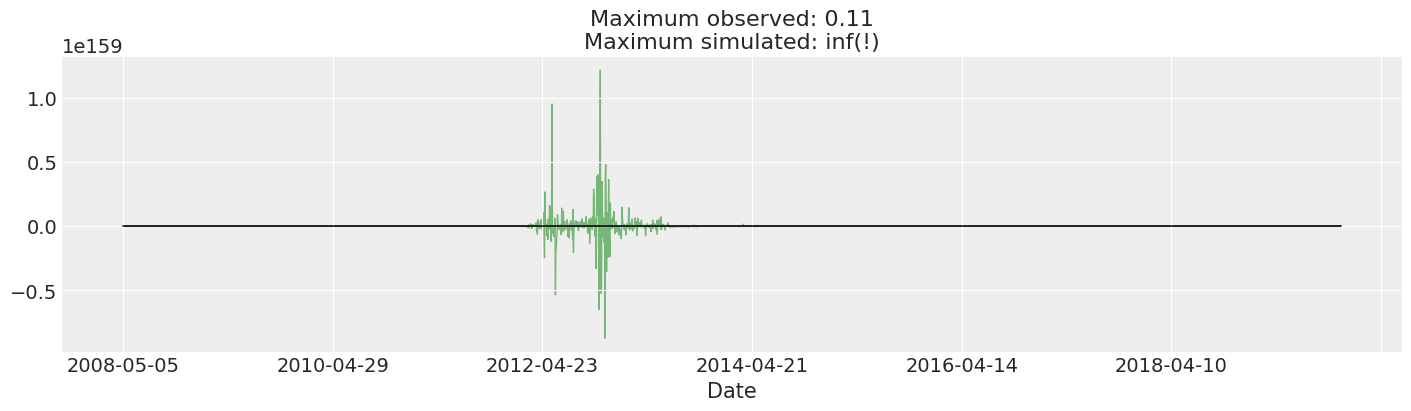

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))
returns["change"].plot(ax=ax, lw=1, color="black")
ax.plot(
    prior_predictive["returns"][:, 0::10],
    "g",
    alpha=0.5,
    lw=1,
    zorder=-10,
)

max_observed, max_simulated = np.max(np.abs(returns["change"])), np.max(
    np.abs(prior_predictive["returns"].values)
)
ax.set_title(f"Maximum observed: {max_observed:.2g}\nMaximum simulated: {max_simulated:.2g}(!)");

MODELO DE AJUSTE

Una vez que estemos satisfechos con nuestro modelo, podemos muestrear desde la parte posterior.

In [ ]:
with stochastic_vol_model:
    idata.extend(pm.sample(random_seed=rng))

posterior = az.extract(idata)
posterior["exp_volatility"] = np.exp(posterior["volatility"])

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/tmp/ipython-input-1806954326.py:5: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'sample'} to avoid an error in the future.
  posterior["exp_volatility"] = np.exp(posterior["volatility"])


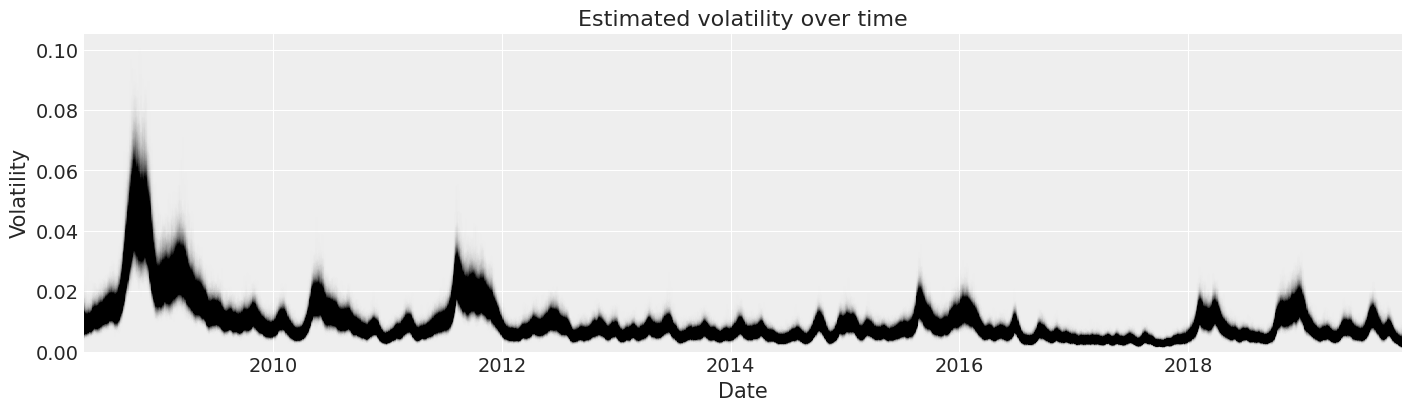

In [ ]:
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = posterior["exp_volatility"]
x_vals = y_vals.time.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");

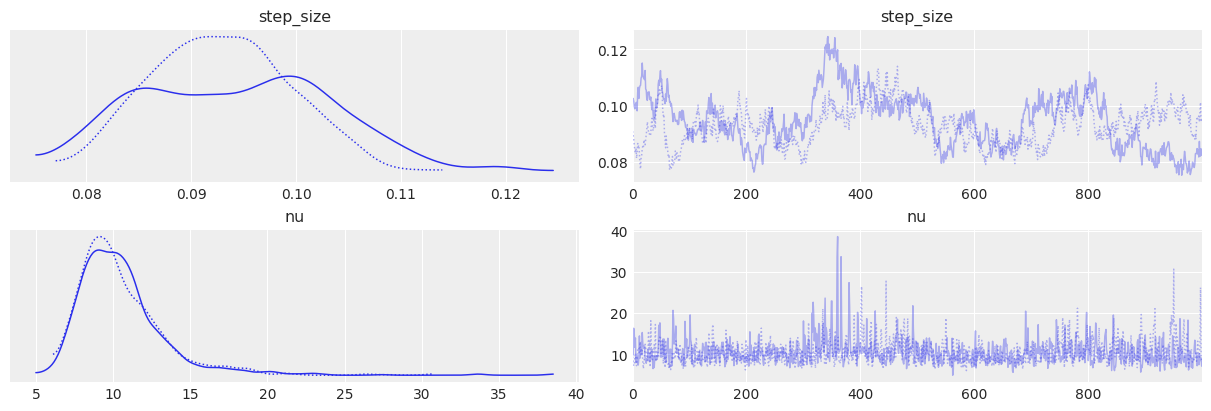

In [ ]:
az.plot_trace(idata, var_names=["step_size", "nu"]);

In [ ]:
with stochastic_vol_model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=rng))

posterior_predictive = az.extract(idata, group="posterior_predictive")

Output()

Finalmente, podemos utilizar la distribución predictiva posterior para ver cómo la volatilidad aprendida podría haber afectado los retornos.

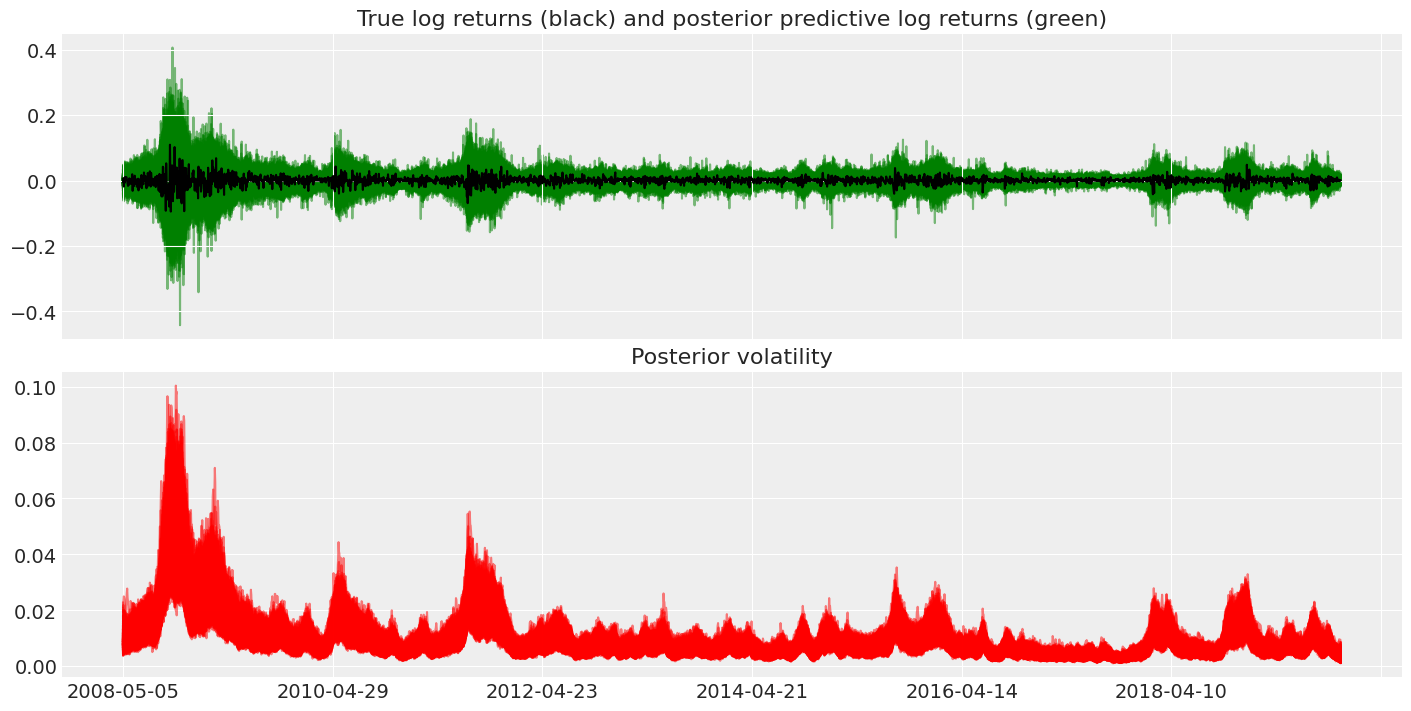

In [ ]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 7), sharex=True)
returns["change"].plot(ax=axes[0], color="black")

axes[1].plot(posterior["exp_volatility"], "r", alpha=0.5)
axes[0].plot(
    posterior_predictive["returns"],
    "g",
    alpha=0.5,
    zorder=-10,
)
axes[0].set_title("True log returns (black) and posterior predictive log returns (green)")
axes[1].set_title("Posterior volatility");